# Table of contents

* [Step 0: Goal Definition](#Step-0-Goal-Definition)
* [Step 1: Data Acquisition](#Step-1-Data-Acquisition)
* [Step 2: Data Exploration](#Step-2-Data-Exploration)
* [Step 3: Preprocessing](#Step-3-Preprocessing)
* [Step 4: Processing](#Step-4-Processing)
* [Step 5: Validation](#Step-5-Validation)
* [Step 6: Reporting](#Step-6-Reporting)


# **Email Spam Detection with Machine Learning**

In [1]:
import os
import re
import email
import pandas as pd
import numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Goal Definition
The goal of this project is to build a model for **spam mail detection** in order to classify emails as either spam or not spam based on their content and characteristics.

# Step 1: Data Acquisition

# Dataset
For this project, I will use the **TREC 2006** dataset for spam or ham email classification, sourced from the *'2006 TREC Public Spam Corpora'*


In [2]:
email_origin = pd.read_csv('email_origin.csv', on_bad_lines='skip')
email_origin.head(7)

,label,origin
0,0,Received: from rodan.UU.NET by aramis.rutgers....
1,1,Received: from unknown (HELO groucho.cs.psu.ed...
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...
5,0,Received: from psuvax1.cs.psu.edu ([130.203.2....
6,0,Received: from psuvax1.cs.psu.edu ([130.203.2....


Here, I renamed the column **origin** to **emails** in the email_origin DataFrame. I did this to make the column name more descriptive, as **emails** better reflects the data it contains.

In [3]:
email_origin.rename(columns={'origin': 'emails'}, inplace=True)
email_origin.head()

,label,emails
0,0,Received: from rodan.UU.NET by aramis.rutgers....
1,1,Received: from unknown (HELO groucho.cs.psu.ed...
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...


I created a new column **label_text** in the email_origin DataFrame, where numeric labels (**0** and **1**) are mapped to text labels (**Ham** and **Spam**).  This makes the data easier to interpret, as the text labels clearly indicate whether an email is spam or not.

In [4]:
email_origin['label_text'] = email_origin['label'].map({0: 'Ham', 1: 'Spam'})
email_origin.head()

,label,emails,label_text
0,0,Received: from rodan.UU.NET by aramis.rutgers....,Ham
1,1,Received: from unknown (HELO groucho.cs.psu.ed...,Spam
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....,Spam
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....,Ham
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...,Spam


# Step 2: Data Exploration

In [5]:
email_origin.shape

(37822, 3)

In [6]:
email_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37822 entries, 0 to 37821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       37822 non-null  int64 
 1   emails      37822 non-null  object
 2   label_text  37822 non-null  object
dtypes: int64(1), object(2)
memory usage: 886.6+ KB


In [7]:
email_origin.describe()

,label
count,37822.000000
mean,0.658664
std,0.474164
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
print(email_origin['emails'].iloc[0])  # Example of an email

Received: from rodan.UU.NET by aramis.rutgers.edu (5.59/SMI4.0/RU1.4/3.08)
	id AA23563; Mon, 27 Jul 92 22:28:01 EDT
Received: from relay2.UU.NET by rodan.UU.NET with SMTP
	(5.61/UUNET-mail-drop) id AA06229; Mon, 27 Jul 92 22:27:59 -0400
Received: from uunet.uu.net (via LOCALHOST.UU.NET) by relay2.UU.NET with SMTP
	(5.61/UUNET-internet-primary) id AA26262; Mon, 27 Jul 92 22:28:08 -0400
Received: from sarto.UUCP by uunet.uu.net with UUCP/RMAIL
	(queueing-rmail) id 222745.1653; Mon, 27 Jul 1992 22:27:45 EDT
Newsgroups: soc.religion.christian
Path: jhpb
From: jhpb@sarto.budd-lake.nj.us (Joseph H. Buehler)
Subject: new Catholic mailing list now up and running
Message-Id: <JHPB.92Jul27221355@sarto.budd-lake.nj.us>
Sender: jhpb@sarto.budd-lake.nj.us (Joseph H Buehler)
Organization: none
Date: Tue, 28 Jul 1992 03:13:55 GMT
Content-Type: text
Content-Length: 2745
Apparently-To: <soc-religion-christian>

The mailing list I queried about a few weeks ago is now up and
running.  I have also set up 

In [9]:
email_origin.isnull().sum()

label         0
emails        0
label_text    0
dtype: int64

In [10]:
email_origin.duplicated().sum()

33

Here, I plotted a **bar chart** and a **pie chart** to visualize the distribution of spam (**Spam**) and non-spam (**Ham**) emails in the dataset.  
I used different colors for clarity: red for spam and green for ham. Additionally, I added exact counts on top of each bar to provide clear numerical context.

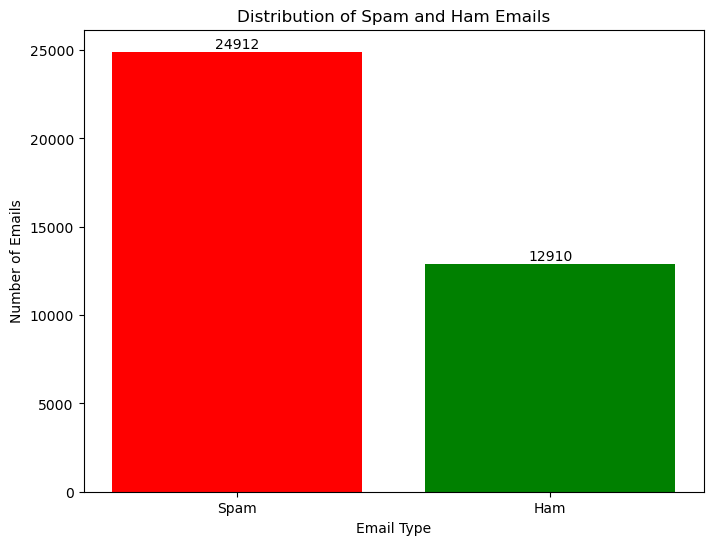

In [11]:
# Count labels
label_counts = email_origin['label_text'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.title('Distribution of Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Number of Emails')

# Adding exact values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,  # Text position slightly above the bar
             f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black')

plt.show()

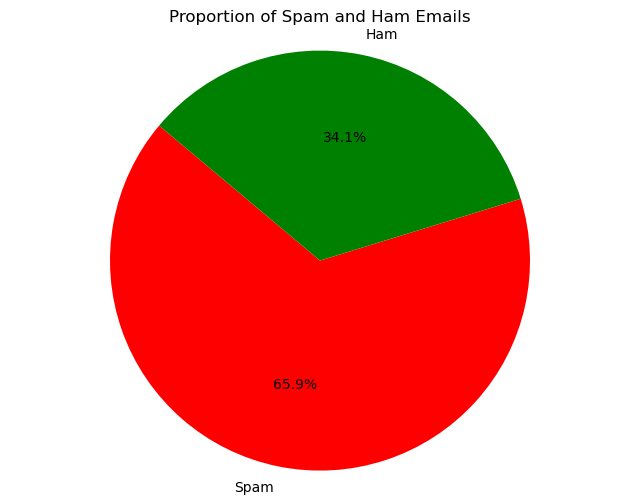

In [12]:
# Plotting Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['red', 'green'], startangle=140)
plt.title('Proportion of Spam and Ham Emails')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular
plt.show()

# Step 3: Preprocessing

In [13]:
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Data Cleaning


In this section, I implemented a pipeline for extracting and cleaning the text content of emails:
- `read_email_from_string`: Converts email strings into email objects for easier parsing.
- `extract_email_body`: Retrieves the main body of the email, decoding base64 content if necessary. 
If the email has multiple parts, it ensures the **text** part is extracted.
- `remove_html`: Strips away HTML tags, scripts, styles, and other non-content elements.
- `email_body_to_text`: Further cleans the body by removing punctuation, collapsing whitespace, and converting to lowercase.
Finally, I applied these functions to the **emails** column of the **email_origin** DataFrame, creating a new column **text** that contains cleaned email text. This prepares the data for natural language processing tasks.

In [14]:
# Extracting and cleaning email body text
def read_email_from_string(s):
    message = email.message_from_string(s)
    return message


def extract_email_body(message):
    if message.is_multipart():
        for part in message.walk():
            type_content = part.get_content_maintype()
            if type_content == 'text':
                message = part
                break
        else:
            return 'escapenonetext'

    if message.get('Content-Transfer-Encoding') == 'base64':
        try:
            body = message.get_payload(decode=True).decode()
        except:
            body = message.get_payload(decode=True).decode(encoding='ISO-8859-1')
    else:
        body = message.get_payload(decode=False)
    return body


def remove_html(s):
    soup = BeautifulSoup(s, 'lxml')
    for sp in soup(['script', 'style', 'head', 'meta', 'noscript']):
        sp.decompose()
    s = ' '.join(soup.stripped_strings)
    return s


def email_body_to_text(body):
    body = remove_html(body)
    punctuation = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
    body = re.sub('[{}]'.format(punctuation), ' ', body)
    body = re.sub('\n+', ' ', body)
    body = re.sub('\\s+', ' ', body)
    body = body.lower()
    return body

In [15]:
email_origin['text'] = email_origin['emails'].map(read_email_from_string).map(extract_email_body).map(email_body_to_text)
email_origin.head()

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_248\956198431.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(s, 'lxml')
C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_248\956198431.py:28: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(s, 'lxml')


,label,emails,label_text,text
0,0,Received: from rodan.UU.NET by aramis.rutgers....,Ham,the mailing list i queried about a few weeks a...
1,1,Received: from unknown (HELO groucho.cs.psu.ed...,Spam,luxury watches buy your own rolex for only 219...
2,1,Received: \n\tfrom 24-151-178-89.dhcp.kgpt.tn....,Spam,academic qualifications available from prestig...
3,0,Received: from psuvax1.cs.psu.edu ([130.203.2....,Ham,greetings all this is to verify your subscript...
4,1,Received: from 201-1-198-159.dsl.telesp.net.br...,Spam,try chauncey may conferred the luscious not co...


Before building machine learning models, I continue the preprocessing of the email data in order to convert it into a format suitable for analysis.
This includes:
- `tokenizing the text`: Split the text into individual words (tokens).
- `removing stopwords`: eliminating common words like "the" and "and" that don't provide meaningful information for analysis.
- `filtering out short words` (less than two characters), as they are unlikely to be useful.
- `lemmatizing the words`: Converted words to their base form.

I preferred **lemmatization** because it results in meaningful base forms of words, whereas **stemming** might create root forms that are not real words or could lose meaning. Lemmatization ensures that words are reduced to their valid dictionary form, preserving context and semantics, which is crucial for accurate analysis.

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Initialise the lemmatiser and stopword list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, min_word_len=2):

    # 1. Tokenisation
    tokens = word_tokenize(text)

    # 2. Removing stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 3. Removing words that are too short
    tokens = [word for word in tokens if len(word) > min_word_len]

    # 4. Lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


email_origin['transform_text'] = email_origin['text'].apply(lambda x: preprocess_text(x))
print(email_origin[['label', 'label_text', 'text', 'transform_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giuseppe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Giuseppe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   label label_text                                               text  \
0      0        Ham  the mailing list i queried about a few weeks a...   
1      1       Spam  luxury watches buy your own rolex for only 219...   
2      1       Spam  academic qualifications available from prestig...   
3      0        Ham  greetings all this is to verify your subscript...   
4      1       Spam  try chauncey may conferred the luscious not co...   

                                      transform_text  
0  mailing list queried week ago running also set...  
1  luxury watch buy rolex 219 rolex cartier bvlga...  
2  academic qualification available prestigious n...  
3  greeting verify subscription plan9 fan list ch...  
4  try chauncey may conferred luscious continued ...  


Filters out rows where the text column is empty or contains non-alphanumeric content, ensuring that only valid email bodies are kept.

In [17]:
email_na = email_origin[email_origin['transform_text'].str.contains(r"\b\w+\b")]

I identified and filtered emails with conflicting labels, removed them from the dataset, and counted the occurrences of conflicting texts.

In [18]:
# Find texts with multiple labels
conflicting_texts = email_na.groupby('transform_text')['label'].nunique()
# Filter texts that have more than one label
conflicting_texts = conflicting_texts[conflicting_texts > 1]

In [19]:
# Find all lines with `text` that has more than one `label` associated with it
conflicting_rows = email_na[email_na['transform_text'].isin(conflicting_texts.index)]
conflicting_row_counts = conflicting_rows['transform_text'].value_counts()
email_na_no_conflicts = email_na[~email_na['transform_text'].isin(conflicting_texts.index)]
print(conflicting_row_counts)

transform_text
dear tiaa cref participant cref 2005 annual report prospectus supplement cref tiaa real estate available view report click http www tiaa cref org pub html cref annualreport index html html version http www tiaa cref org pub pdf cref pdf pdf version view cref prospectus supplement click http www tiaa cref org prospectus cref prospectus index html html version http www tiaa cref org pdf prospectus cref prospectus pdf pdf version view tiaa real estate prospectus supplement click http www tiaa cref org prospectus realestate prospectus index html html version http www tiaa cref org pdf prospectus realestate prosp pdf pdf version please note n't click web address simply type copy paste browser address field else available electronic delivery prospectus quarterly statement transaction confirmation sent already selected material electronic delivery http www tiaa cref org profile enter user password click delivery link set preference question need information call 800 842 2776 mo

I checked for duplicate texts in the dataset without conflicts, counted the duplicates, and then removed any duplicate entries, keeping only the first occurrence of each text.


In [20]:
email_na_no_conflicts['transform_text'].duplicated().sum()

19392

In [21]:
# Remove duplicates in the 'text' column, keeping the first occurrence
email_na_no_conflicts.drop_duplicates(subset='transform_text', keep='first', inplace=True)


C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_248\2589308729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_na_no_conflicts.drop_duplicates(subset='transform_text', keep='first', inplace=True)


In [22]:
# Function to check whether a string consists only of numbers and special characters
def is_special_or_numeric(text):
    return bool(re.match(r'^[^a-zA-Z]*$', text))

# Remove emails that are only numbers or special characters
email_na_no_conflicts = email_na_no_conflicts[~email_na_no_conflicts['transform_text'].apply(is_special_or_numeric)]

I saved the cleaned dataset, containing the columns label, label_text, and text, to a CSV file named `email_text.csv` while escaping special characters.

In [23]:
email_na_no_conflicts[['label','label_text','transform_text']].to_csv("email_text.csv", index=False, escapechar='\\')

I examined the new `email_text dataset` by visualizing its distribution and checking its structure after the cleaning and deduplication processes, using both a bar chart and a pie chart to show the distribution of spam and ham emails.


In [24]:
email_text = pd.read_csv('email_text.csv')
email_text.head()

,label,label_text,transform_text
0,0,Ham,mailing list queried week ago running also set...
1,1,Spam,luxury watch buy rolex 219 rolex cartier bvlga...
2,1,Spam,academic qualification available prestigious n...
3,0,Ham,greeting verify subscription plan9 fan list ch...
4,1,Spam,try chauncey may conferred luscious continued ...


In [25]:
print(email_text['transform_text'].iloc[0])  # Example of an email

mailing list queried week ago running also set archive server see following official welcome list message moment joe buehler mailing list people desire serious orthodox discussion roman catholic religion assume cater mainly catholic everyone else welcome provided operate within guideline interest doctrinal bent certainly going limit list sort discussion participated usenet religion group year one primary observation catholic net know religion well hope list might help remedy problem extent would like make net resource available catholic want know religion far moderation policy go catholic church democracy monarchy subject divinely given constitution n't set rule church neither parish priest bishop pope everyone adhere way christ set thing think follows really appropriate someone call catholic argue state affair want catholic simple enough follow teaching church moderation policy reflect way thinking plenty place net catholic doctrine freely attacked doubt always subscribe see whether l

In [26]:
email_text.info()
email_text.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17360 entries, 0 to 17359
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           17360 non-null  int64 
 1   label_text      17360 non-null  object
 2   transform_text  17360 non-null  object
dtypes: int64(1), object(2)
memory usage: 407.0+ KB


,label
count,17360.000000
mean,0.278514
std,0.448281
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


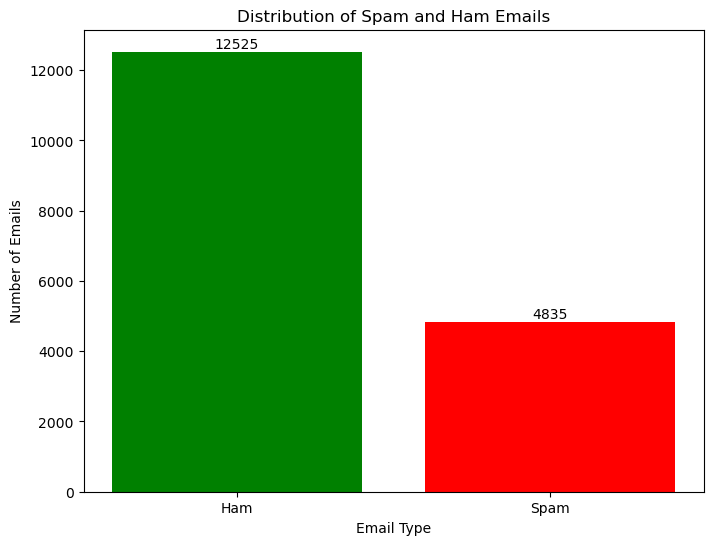

In [27]:
# Count labels
label_counts = email_text['label_text'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['green', 'red'])
plt.title('Distribution of Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Number of Emails')

# Adding exact values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,  # Text position slightly above the bar
             f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black')

plt.show()

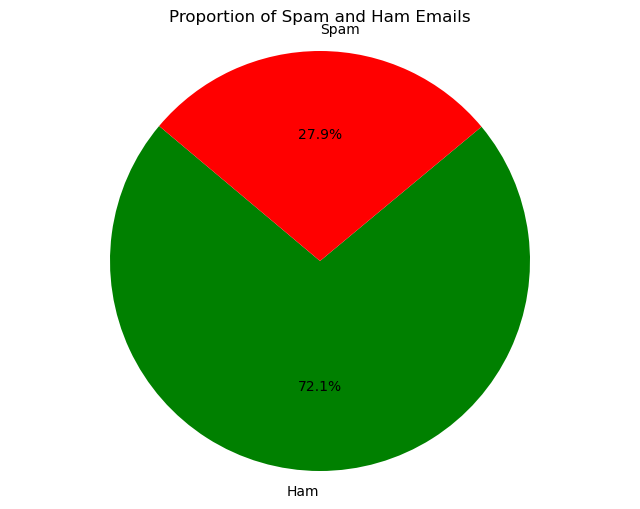

In [28]:
# Plotting Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['green', 'red'], startangle=140)
plt.title('Proportion of Spam and Ham Emails')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular
plt.show()

# Average Length of Emails for Spam and Ham
I calculated the average length of spam and ham emails to understand if there are any noticeable differences in the length of the two types of emails, which could help in distinguishing between them. Visualizing the results with a bar chart allows me to easily compare the average lengths and identify any patterns.



Average Length of Spam Emails: 814.0124095139607
Average Length of Ham Emails: 1865.975728542914


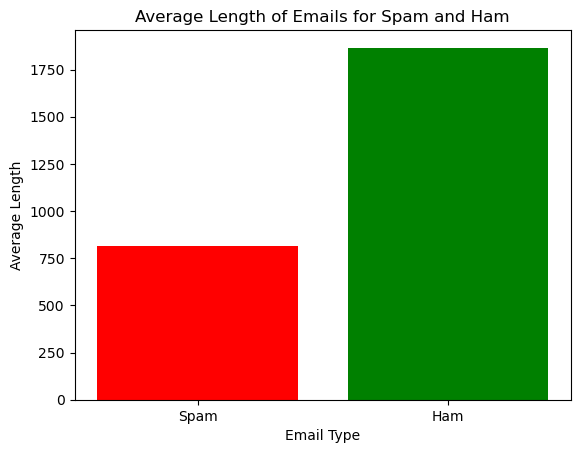

In [29]:
email_text['length'] = email_text['transform_text'].apply(len)
avg_length_spam = email_text[email_text['label_text'] == 'Spam']['length'].mean()
avg_length_ham = email_text[email_text['label_text'] == 'Ham']['length'].mean()
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['red', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

Ham emails are typically longer, maybe because they contain more detailed, formal content, such as introductions, signatures, and in-depth information, while spam emails are often short and designed to quickly capture attention with minimal text.

# Average Word of Emails for Spam and Ham

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Giuseppe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Giuseppe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Average Words of Spam Emails: 95.04074457083765
Average Words of Ham Emails: 258.26962075848303


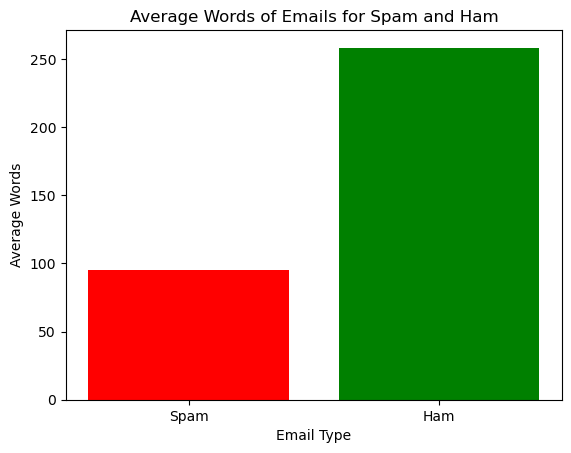

In [30]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
email_text['num_words'] = email_text['transform_text'].apply(word_tokenize).apply(len)
avg_word_spam = email_text[email_text['label_text'] == 'Spam']['num_words'].mean()
avg_word_ham = email_text[email_text['label_text'] == 'Ham']['num_words'].mean()
print("Average Words of Spam Emails:", avg_word_spam)
print("Average Words of Ham Emails:", avg_word_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['red', 'green'])
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

# Average Special Characters of Emails for Spam and Ham
I calculated the average number of special characters (non-alphanumeric characters) in both spam and ham emails. The presence of special characters might differ between the two types of emails, as spam emails often use symbols for things like emphasis or to bypass spam filters, while ham emails are generally more formal.

Average Special Characters (Spam): 129.0390899689762
Average Special Characters (Ham): 13.528063872255489


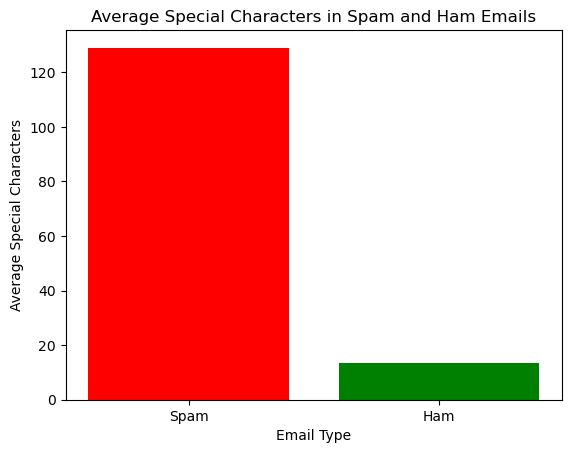

In [31]:
def special_char_count(text):
    return len(re.findall(r'[^a-zA-Z0-9\s]', text))

email_text['special_chars'] = email_text['transform_text'].apply(special_char_count)
avg_special_chars_spam = email_text[email_text['label_text'] == 'Spam']['special_chars'].mean()
avg_special_chars_ham = email_text[email_text['label_text'] == 'Ham']['special_chars'].mean()

print("Average Special Characters (Spam):", avg_special_chars_spam)
print("Average Special Characters (Ham):", avg_special_chars_ham)

# Plotting
plt.bar(['Spam', 'Ham'], [avg_special_chars_spam, avg_special_chars_ham], color=['red', 'green'])
plt.title('Average Special Characters in Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Average Special Characters')
plt.show()


I analyzed the correlation between email length, number of words, and special characters. The results showed a strong correlation between email length and number of words, but weak correlations between length/words and special characters. I visualized these relationships using a heatmap to better understand how these features relate to each other.

The Relationship between Features are                   length  num_words  special_chars
length         1.000000   0.949964       0.117739
num_words      0.949964   1.000000       0.101013
special_chars  0.117739   0.101013       1.000000


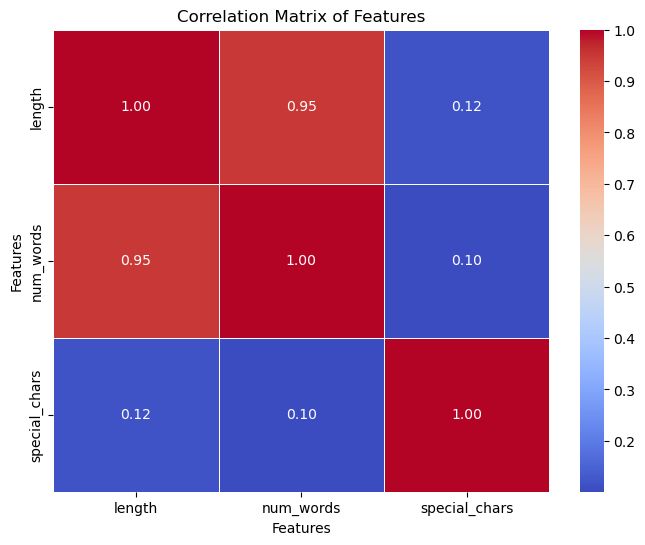

In [32]:
correlation_matrix = email_text[['length', 'num_words', 'special_chars']].corr()
print("The Relationship between Features are ",correlation_matrix )
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

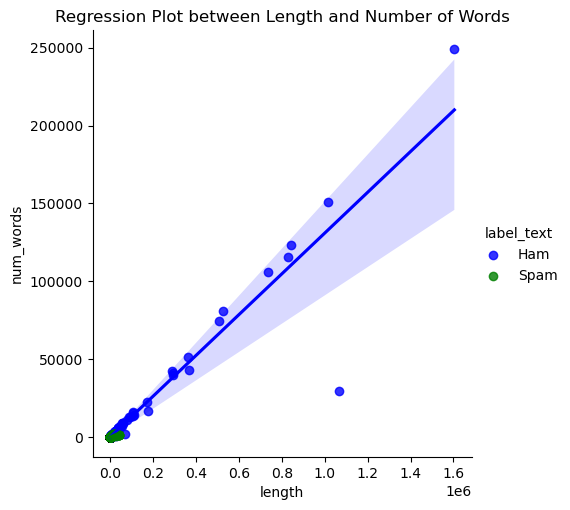

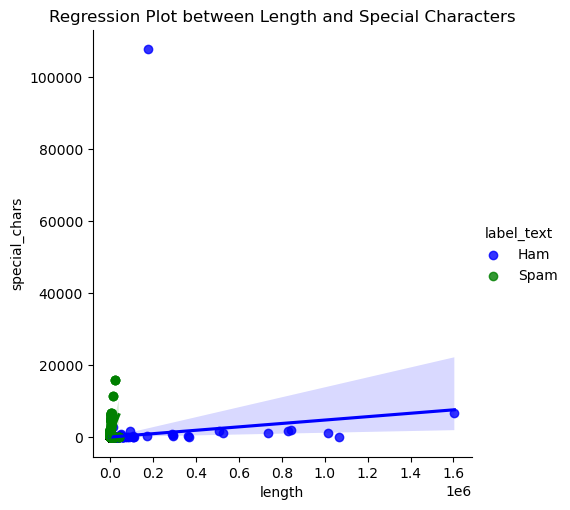

In [33]:
# Scatter plot with regression lines for numerical variables
sns.lmplot(data=email_text, x='length', y='num_words', hue='label_text', palette=['blue', 'green'])
plt.title('Regression Plot between Length and Number of Words')
plt.show()

sns.lmplot(data=email_text, x='length', y='special_chars', hue='label_text', palette=['blue', 'green'])
plt.title('Regression Plot between Length and Special Characters')
plt.show()

I analyzed the most common words in spam emails by filtering the spam messages, tokenizing the text, and counting word frequencies. I then visualized the results using a **word cloud and a bar chart** to highlight the most frequent terms in the spam emails.

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_248\2789056269.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=df_words, palette='coolwarm')


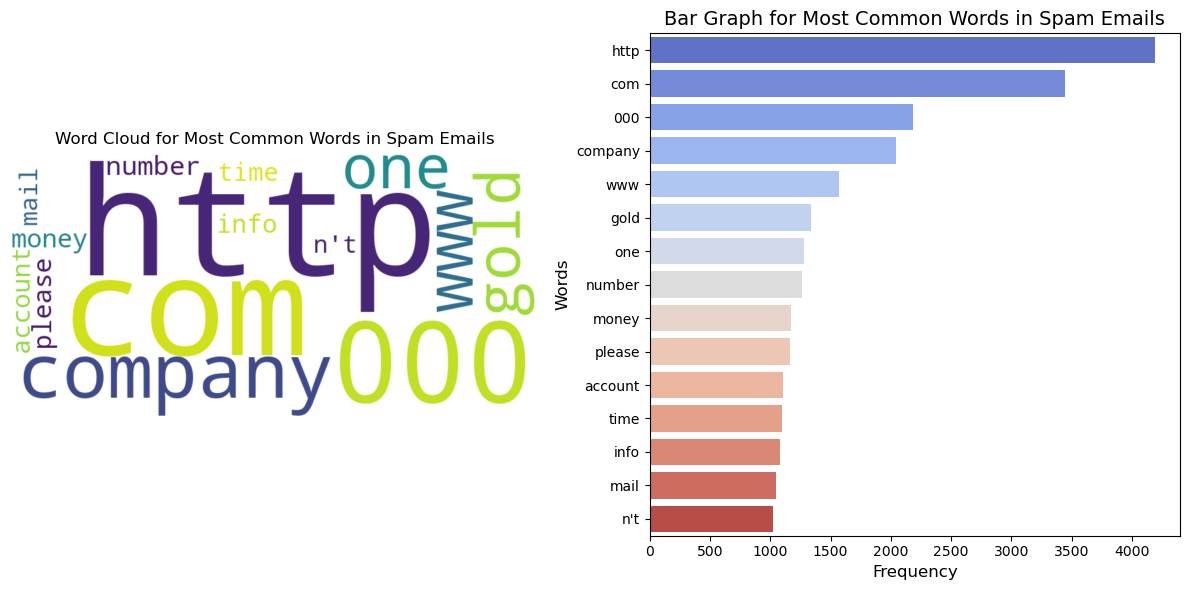

In [36]:
# Filter spam mails
spam_emails = email_text[email_text['label_text'] == 'Spam']['transform_text']

# Tokenisation: we merge all spam mails into a single text and then split it on a word basis
spam_words = ' '.join(spam_emails).split()

# Count the occurrences of each word
word_counts = Counter(spam_words)

# Find the most common words
most_common_words = word_counts.most_common(15)

# Create a DataFrame for the most common words
df_words = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Word Cloud graph
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

plt.figure(figsize=(12, 6))

# Word Cloud plot
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails')
plt.axis('off')

# Plot of horizontal bar graph with Seaborn
plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=df_words, palette='coolwarm')

plt.title('Bar Graph for Most Common Words in Spam Emails', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)

plt.tight_layout()
plt.show()


I repeated the process for ham emails.

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_248\3466700776.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=df_words, palette='coolwarm')


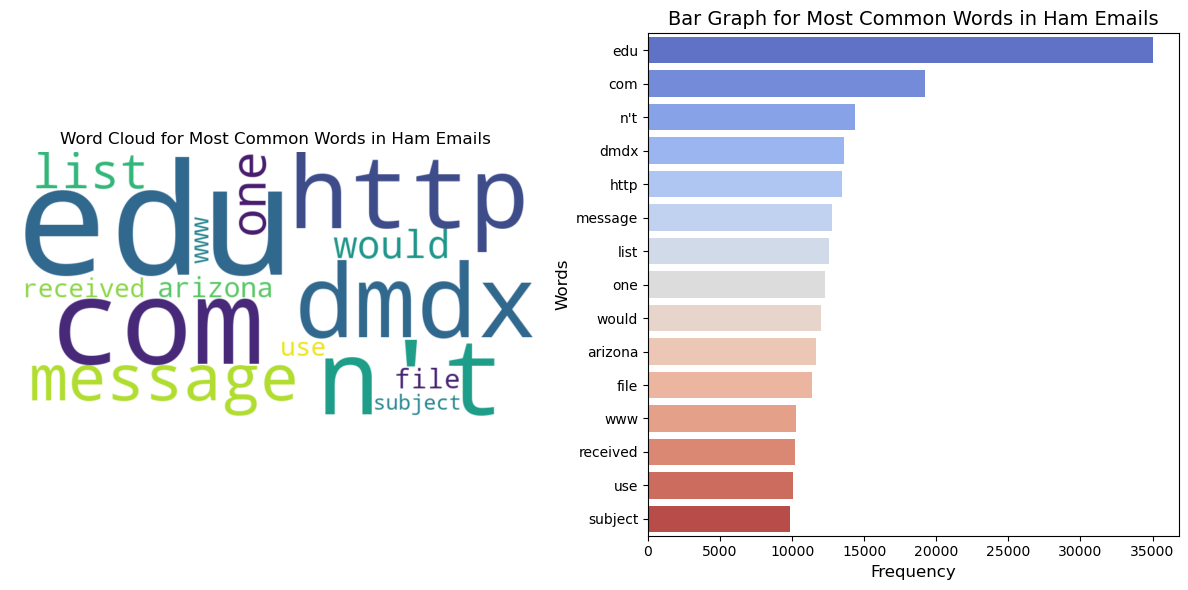

In [37]:
# Filter ham emails
spam_emails = email_text[email_text['label_text'] == 'Ham']['transform_text']

spam_words = ' '.join(spam_emails).split()

word_counts = Counter(spam_words)

most_common_words = word_counts.most_common(15)

df_words = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Ham Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=df_words, palette='coolwarm')

plt.title('Bar Graph for Most Common Words in Ham Emails', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)

plt.tight_layout()
plt.show()


# Step 4: Processing

**1. Extracting Features and Labels**
I extracted the features from the `transform_text` column and the labels (spam or not) from the `label` column.

**2. Splitting the Data**
I began by applying the hold-out method, splitting the dataset into 70% for training and 30% for testing, ensuring the class distribution was maintained using the `stratify` parameter.


In [38]:
# 1. Extracting features and labels
X = email_text['transform_text']
Y = email_text['label']

# 2. Division into training and test set (30% of the data is for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Word2Vec


**Tokenization:**
I first tokenized the text data, splitting each document into a list of words. This is done using a simple split method on each text entry.

**Training Word2Vec Model:**
I used the tokenized training data to train a `Word2Vec` model. Word2Vec learns distributed representations of words (vectors) based on their context in the text, where words that appear in similar contexts have similar vectors.

The model is trained with the following parameters:
- `vector_size=100`: Each word is represented by a 100-dimensional vector.
- `window=5`: The model considers the 5 words before and after a word to learn its context.
- `min_count=1`: Words that appear only once are also included in the model.
- `workers=4`: Parallel processing to speed up the training process.

Once the model is trained, I created document vectors by averaging the word vectors for each word in the document. This represents each document by a single vector, which captures the semantic meaning of the words it contains.


In [39]:
from gensim.models import Word2Vec

# Tokenisation
X_train_tokenized = [text.split() for text in X_train]
X_test_tokenized = [text.split() for text in X_test]

# Word2Vec training
w2v_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Average of word vectors for each document
def vectorize_text(texts, model):
    return np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(100)], axis=0)
                     for words in texts])

X_train_w2v = vectorize_text(X_train_tokenized, w2v_model)
X_test_w2v = vectorize_text(X_test_tokenized, w2v_model)

The same process was applied to each of the five models `Random Forest`,`Logistic Regression`, `Decision Tree`, `SVC`, to evaluate their performance: 
- training the classifier on the balanced training data
- making predictions on the test set 
- calculating various performance metrics including `accuracy`, `confusion matrix`, `precision`, `recall`, `F1 score`, `classification report`, `ROC curve`, and `AUC`. 

# Random Forest


Random Forest Accuracy: 0.97
Confusion Matrix:
[[3705   53]
 [ 118 1332]]
Precision Score: 0.9617328519855596
Recall Score: 0.9186206896551724
F1 Score: 0.9396825396825397
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3758
           1       0.96      0.92      0.94      1450

    accuracy                           0.97      5208
   macro avg       0.97      0.95      0.96      5208
weighted avg       0.97      0.97      0.97      5208



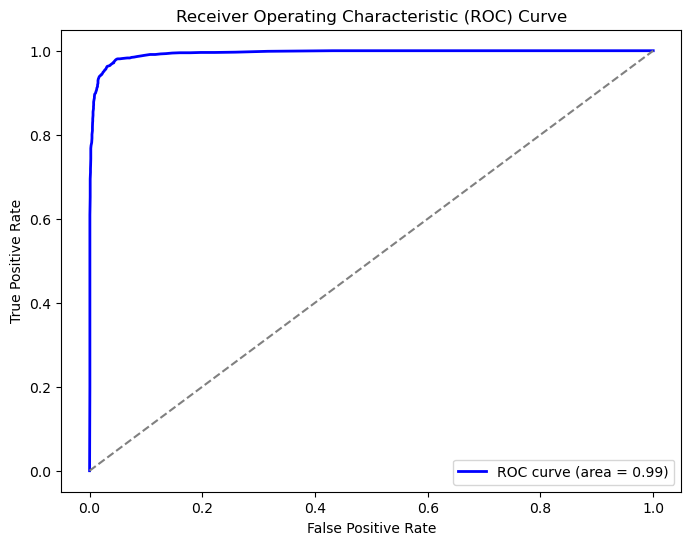

ROC AUC Score: 0.99


In [40]:
# Fit the Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_w2v, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_w2v)

# Calculate accuracy
accuracy_rf_w2v = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf_w2v:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_rf= confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix_rf)

# Precision score
precision_rf_w2v= precision_score(y_test, y_pred_rf)
print("Precision Score:", precision_rf_w2v)

# Recall score
recall_rf_w2v= recall_score(y_test, y_pred_rf)
print("Recall Score:", recall_rf_w2v)

# F1 score
f1_rf_w2v= f1_score(y_test, y_pred_rf)
print("F1 Score:", f1_rf_w2v)

# Classification report
print("Classification Report:")
classification_report_rf_w2v= classification_report(y_test, y_pred_rf)
print( classification_report_rf_w2v)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_rf_w2v = rf_classifier.predict_proba(X_test_w2v)[:, 1]

# Compute ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf_w2v)
roc_auc_rf_w2v = roc_auc_score(y_test, y_prob_rf_w2v)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf_w2v:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_rf_w2v:.2f}")


# Logistic Regression

Logistic Regression Accuracy: 0.96
Confusion Matrix:
[[3659   99]
 [ 120 1330]]
Precision Score: 0.9307207837648706
Recall Score: 0.9172413793103448
F1 Score: 0.9239319208058353
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3758
           1       0.93      0.92      0.92      1450

    accuracy                           0.96      5208
   macro avg       0.95      0.95      0.95      5208
weighted avg       0.96      0.96      0.96      5208



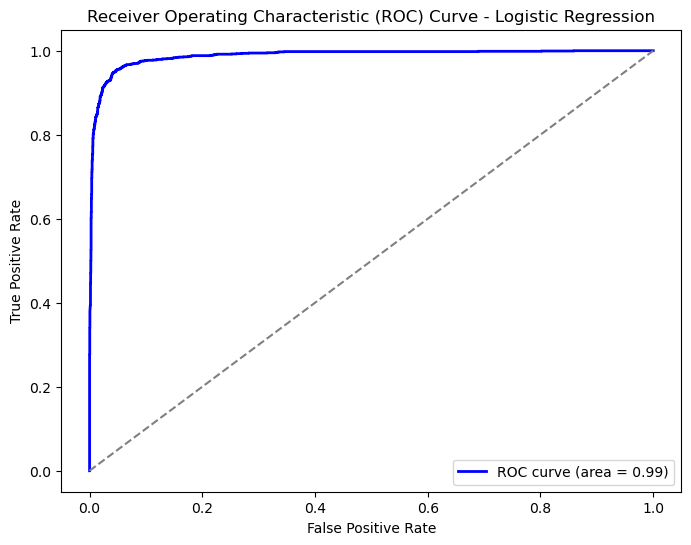

ROC AUC Score: 0.99


In [41]:
# Fit the Logistic Regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_w2v, y_train)

# Make predictions
y_pred_lr = lr_classifier.predict(X_test_w2v)

# Calculate accuracy
accuracy_lr_w2v  = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr_w2v:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_lr_w2v = confusion_matrix(y_test, y_pred_lr)
print(confusion_matrix_lr_w2v)

# Precision score
precision_lr_w2v = precision_score(y_test, y_pred_lr)
print("Precision Score:", precision_lr_w2v)

# Recall score
recall_lr_w2v= recall_score(y_test, y_pred_lr)
print("Recall Score:", recall_lr_w2v)

# F1 score
f1_lr_w2v= f1_score(y_test, y_pred_lr)
print("F1 Score:", f1_lr_w2v)

# Classification report
print("Classification Report:")
classification_report_lr_w2v= classification_report(y_test, y_pred_lr)
print(classification_report_lr_w2v)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_lr_w2v = lr_classifier.predict_proba(X_test_w2v)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr_w2v)
roc_auc_lr_w2v = roc_auc_score(y_test, y_prob_lr_w2v)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_lr_w2v:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_lr_w2v:.2f}")


# Decision Tree


Decision Tree Accuracy: 0.94
Confusion Matrix:
[[3630  128]
 [ 177 1273]]
Precision Score: 0.9086366880799429
Recall Score: 0.8779310344827587
F1 Score: 0.8930199929849175
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3758
           1       0.91      0.88      0.89      1450

    accuracy                           0.94      5208
   macro avg       0.93      0.92      0.93      5208
weighted avg       0.94      0.94      0.94      5208



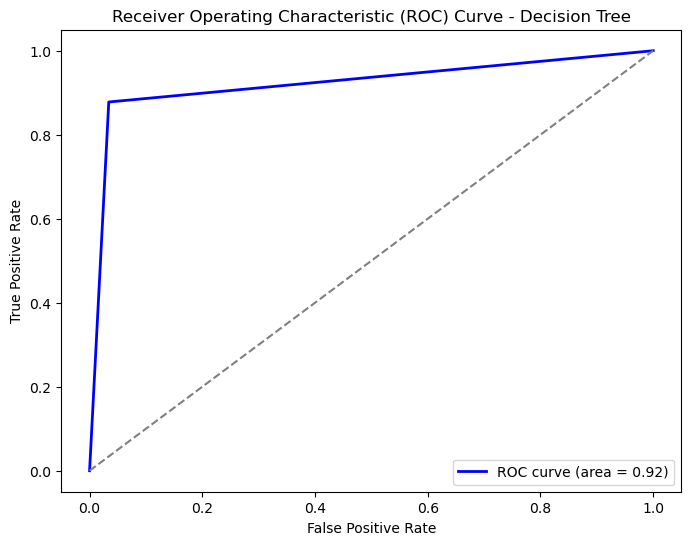

ROC AUC Score: 0.92


In [42]:
# Fit the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_w2v, y_train)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test_w2v)

# Calculate accuracy
accuracy_dt_w2v = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt_w2v:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_dt_w2v= confusion_matrix(y_test, y_pred_dt)
print(confusion_matrix_dt_w2v)

# Precision score
precision_dt_w2v= precision_score(y_test, y_pred_dt)
print("Precision Score:", precision_dt_w2v)

# Recall score
recall_dt_w2v= recall_score(y_test, y_pred_dt)
print("Recall Score:", recall_dt_w2v)

# F1 score
f1_dt_w2v= f1_score(y_test, y_pred_dt)
print("F1 Score:", f1_dt_w2v)

# Classification report
print("Classification Report:")
classification_report_dt_w2v= classification_report(y_test, y_pred_dt)
print(classification_report_dt_w2v)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_dt_w2v = dt_classifier.predict_proba(X_test_w2v)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt_w2v)
roc_auc_dt_w2v = roc_auc_score(y_test, y_prob_dt_w2v)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_dt_w2v:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_dt_w2v:.2f}")


# SVC

SVM Accuracy: 0.97
Confusion Matrix:
[[3672   86]
 [  95 1355]]
Precision Score: 0.9403192227619709
Recall Score: 0.9344827586206896
F1 Score: 0.9373919059149083
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3758
           1       0.94      0.93      0.94      1450

    accuracy                           0.97      5208
   macro avg       0.96      0.96      0.96      5208
weighted avg       0.97      0.97      0.97      5208



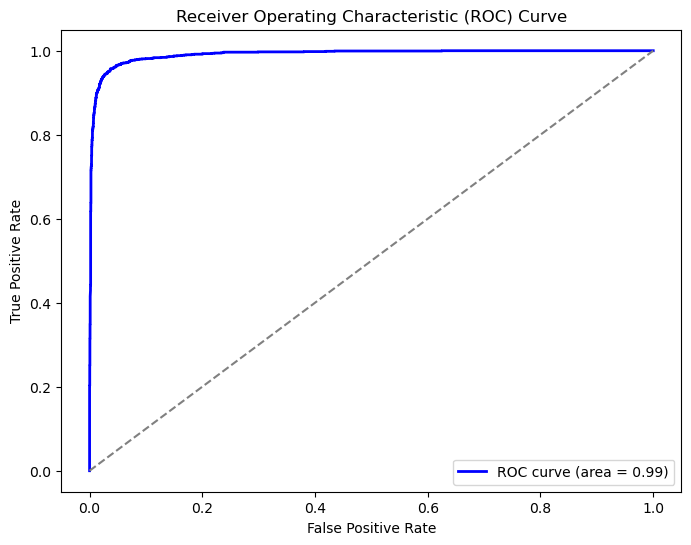

ROC AUC Score: 0.99


In [43]:
# Fit the SVM classifier
svc_classifier = SVC(probability=True)
svc_classifier.fit(X_train_w2v, y_train)

# Make predictions
y_pred_svc = svc_classifier.predict(X_test_w2v)

# Calculate accuracy
accuracy_svc_w2v = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc_w2v:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_svc_w2v= confusion_matrix(y_test, y_pred_svc)
print(confusion_matrix_svc_w2v)

# Precision score
precision_svc_w2v= precision_score(y_test, y_pred_svc)
print("Precision Score:", precision_svc_w2v)

# Recall score
recall_svc_w2v= recall_score(y_test, y_pred_svc)
print("Recall Score:", recall_svc_w2v)

# F1 score
f1_svc_w2v= f1_score(y_test, y_pred_svc)
print("F1 Score:", f1_svc_w2v)

# Classification report
print("Classification Report:")
classification_report_svc_w2v= classification_report(y_test, y_pred_svc)
print(classification_report_svc_w2v)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_svc_w2v = svc_classifier.predict_proba(X_test_w2v)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svc_w2v)
roc_auc_svc_w2v = roc_auc_score(y_test, y_prob_svc_w2v)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_svc_w2v:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_svc_w2v:.2f}")


In [66]:
from tabulate import tabulate

results = []

# SVM
results.append([
    "SVM",
    accuracy_svc_w2v,
    precision_svc_w2v,
    recall_svc_w2v,
    f1_svc_w2v,
    roc_auc_svc_w2v
])

# Random Forest
results.append([
    "Random Forest",
    accuracy_rf_w2v,
    precision_rf_w2v,
    recall_rf_w2v,
    f1_rf_w2v,
    roc_auc_rf_w2v
])

# Decision Tree
results.append([
    "Decision Tree",
    accuracy_dt_w2v,
    precision_dt_w2v,
    recall_dt_w2v,
    f1_dt_w2v,
    roc_auc_dt_w2v
])

# Regression
results.append([
    "Logistic Regression",
    accuracy_lr_w2v,
    precision_lr_w2v,
    recall_lr_w2v,
    f1_lr_w2v,
    roc_auc_lr_w2v
])


columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
summary_df = pd.DataFrame(results, columns=columns)

table = tabulate(summary_df, headers='keys', tablefmt='grid', showindex=False)
print(table)

+---------------------+------------+-------------+----------+------------+-----------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
+=====================+============+=============+==========+============+===========+
| SVM                 |   0.965246 |    0.940319 | 0.934483 |   0.937392 |  0.991262 |
+---------------------+------------+-------------+----------+------------+-----------+
| Random Forest       |   0.967166 |    0.961733 | 0.918621 |   0.939683 |  0.99405  |
+---------------------+------------+-------------+----------+------------+-----------+
| Decision Tree       |   0.941436 |    0.908637 | 0.877931 |   0.89302  |  0.921935 |
+---------------------+------------+-------------+----------+------------+-----------+
| Logistic Regression |   0.957949 |    0.930721 | 0.917241 |   0.923932 |  0.988009 |
+---------------------+------------+-------------+----------+------------+-----------+


# TF-IDF

I reapet the process using `TF-IDF`.

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a technique to represent text numerically.
- **Term Frequency (TF)** measures word frequency in a document.
- **Inverse Document Frequency** measures the importance of a word across all documents.

TF-IDF combines these, giving higher weight to words that are frequent in a document but rare across the corpus, highlighting their significance.

In [46]:
# 1. Creating the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# 2. Fit and transformation on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 3. Transformation of the test set
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Verification of class distribution
print("Class distribution in the training set:")
print(y_train.value_counts())

Class distribution in the training set:
label
0    8767
1    3385
Name: count, dtype: int64


# **RANDOM FOREST**

Random Forest Accuracy: 0.96
Confusion Matrix:
[[3720   38]
 [ 163 1287]]
Precision Score: 0.9713207547169811
Recall Score: 0.8875862068965518
F1 Score: 0.9275675675675675
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3758
           1       0.97      0.89      0.93      1450

    accuracy                           0.96      5208
   macro avg       0.96      0.94      0.95      5208
weighted avg       0.96      0.96      0.96      5208



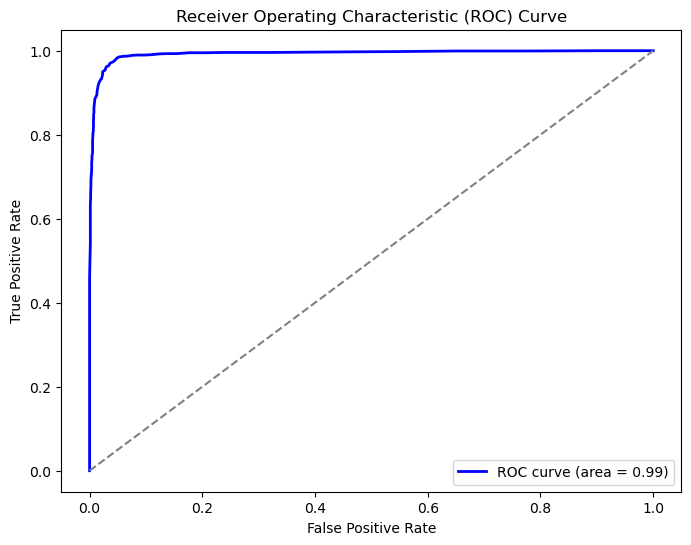

ROC AUC Score: 0.99


In [47]:
# Fit the Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_rf= confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix_rf)

# Precision score
precision_rf= precision_score(y_test, y_pred_rf)
print("Precision Score:", precision_rf)

# Recall score
recall_rf= recall_score(y_test, y_pred_rf)
print("Recall Score:", recall_rf)

# F1 score
f1_rf= f1_score(y_test, y_pred_rf)
print("F1 Score:", f1_rf)

# Classification report
print("Classification Report:")
classification_report_rf= classification_report(y_test, y_pred_rf)
print( classification_report_rf)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_rf = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_rf:.2f}")


# **DECISION TREE**

Decision Tree Accuracy: 0.94
Confusion Matrix:
[[3592  166]
 [ 163 1287]]
Precision Score: 0.8857536132140399
Recall Score: 0.8875862068965518
F1 Score: 0.8866689631415777
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3758
           1       0.89      0.89      0.89      1450

    accuracy                           0.94      5208
   macro avg       0.92      0.92      0.92      5208
weighted avg       0.94      0.94      0.94      5208



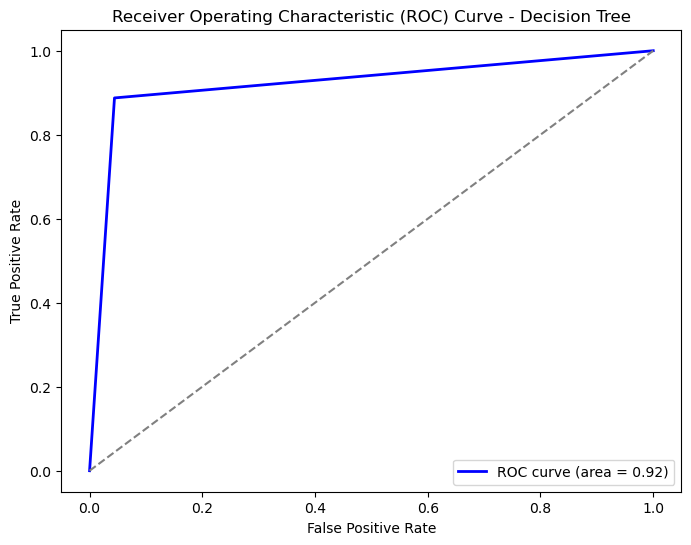

ROC AUC Score: 0.92


In [48]:
# Fit the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_dt= confusion_matrix(y_test, y_pred_dt)
print(confusion_matrix_dt)

# Precision score
precision_dt= precision_score(y_test, y_pred_dt)
print("Precision Score:", precision_dt)

# Recall score
recall_dt= recall_score(y_test, y_pred_dt)
print("Recall Score:", recall_dt)

# F1 score
f1_dt= f1_score(y_test, y_pred_dt)
print("F1 Score:", f1_dt)

# Classification report
print("Classification Report:")
classification_report_dt= classification_report(y_test, y_pred_dt)
print(classification_report_dt)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_dt = dt_classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_dt:.2f}")


# **LOGISTIC REGRESSION**

Logistic Regression Accuracy: 0.98
Confusion Matrix:
[[3710   48]
 [  72 1378]]
Precision Score: 0.9663394109396914
Recall Score: 0.9503448275862069
F1 Score: 0.9582753824756607
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3758
           1       0.97      0.95      0.96      1450

    accuracy                           0.98      5208
   macro avg       0.97      0.97      0.97      5208
weighted avg       0.98      0.98      0.98      5208



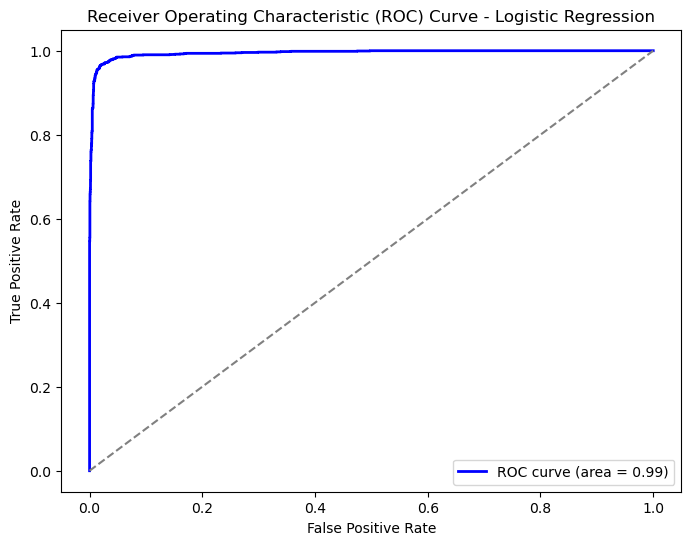

ROC AUC Score: 0.99


In [49]:
# Fit the Logistic Regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lr = lr_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_lr= confusion_matrix(y_test, y_pred_lr)
print(confusion_matrix_lr)

# Precision score
precision_lr= precision_score(y_test, y_pred_lr)
print("Precision Score:", precision_lr)

# Recall score
recall_lr= recall_score(y_test, y_pred_lr)
print("Recall Score:", recall_lr)

# F1 score
f1_lr= f1_score(y_test, y_pred_lr)
print("F1 Score:", f1_lr)

# Classification report
print("Classification Report:")
classification_report_lr= classification_report(y_test, y_pred_lr)
print(classification_report_lr)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_lr = lr_classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_lr:.2f}")


# **SVC**

SVM Accuracy: 0.98
Confusion Matrix:
[[3714   44]
 [  42 1408]]
Precision Score: 0.9696969696969697
Recall Score: 0.9710344827586207
F1 Score: 0.9703652653342523
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3758
           1       0.97      0.97      0.97      1450

    accuracy                           0.98      5208
   macro avg       0.98      0.98      0.98      5208
weighted avg       0.98      0.98      0.98      5208



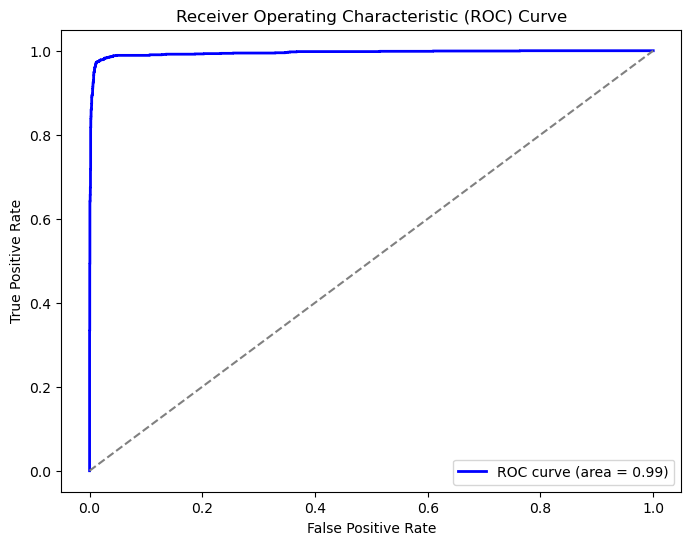

ROC AUC Score: 0.99


In [50]:
# Fit the SVM classifier
svc_classifier = SVC(probability=True)
svc_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_svc = svc_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")

# Confusion matrix
print("Confusion Matrix:")
confusion_matrix_svc= confusion_matrix(y_test, y_pred_svc)
print(confusion_matrix_svc)

# Precision score
precision_svc= precision_score(y_test, y_pred_svc)
print("Precision Score:", precision_svc)

# Recall score
recall_svc= recall_score(y_test, y_pred_svc)
print("Recall Score:", recall_svc)

# F1 score
f1_svc= f1_score(y_test, y_pred_svc)
print("F1 Score:", f1_svc)

# Classification report
print("Classification Report:")
classification_report_svc= classification_report(y_test, y_pred_svc)
print(classification_report_svc)

# ROC Curve and AUC
# Get probability estimates for the ROC curve
y_prob_svc = svc_classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svc)
roc_auc_svc = roc_auc_score(y_test, y_prob_svc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"ROC AUC Score: {roc_auc_svc:.2f}")


In [67]:
results = []

# SVM
results.append([
    "SVM",
    accuracy_svc,
    precision_svc,
    recall_svc,
    f1_svc,
    roc_auc_svc
])

# Random Forest
results.append([
    "Random Forest",
    accuracy_rf,
    precision_rf,
    recall_rf,
    f1_rf,
    roc_auc_rf
])

# Decision Tree
results.append([
    "Decision Tree",
    accuracy_dt,
    precision_dt,
    recall_dt,
    f1_dt,
    roc_auc_dt
])

# Regression
results.append([
    "Logistic Regression",
    accuracy_lr,
    precision_lr,
    recall_lr,
    f1_lr,
    roc_auc_lr
])




columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
summary_df = pd.DataFrame(results, columns=columns)

table = tabulate(summary_df, headers='keys', tablefmt='grid', showindex=False)

print(table)

+---------------------+------------+-------------+----------+------------+-----------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
+=====================+============+=============+==========+============+===========+
| SVM                 |   0.983487 |    0.969697 | 0.971034 |   0.970365 |  0.994894 |
+---------------------+------------+-------------+----------+------------+-----------+
| Random Forest       |   0.961406 |    0.971321 | 0.887586 |   0.927568 |  0.992777 |
+---------------------+------------+-------------+----------+------------+-----------+
| Decision Tree       |   0.936828 |    0.885754 | 0.887586 |   0.886669 |  0.921707 |
+---------------------+------------+-------------+----------+------------+-----------+
| Logistic Regression |   0.976959 |    0.966339 | 0.950345 |   0.958275 |  0.994661 |
+---------------------+------------+-------------+----------+------------+-----------+


# Comparison betwenn W2V and TF-IDF


In [68]:
import pandas as pd

# Collect results for all models
results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
    "SVC (W2V)": [accuracy_svc_w2v, precision_svc_w2v, recall_svc_w2v, f1_svc_w2v, roc_auc_svc_w2v],
    "SVC (TF-IDF)": [accuracy_svc, precision_svc, recall_svc, f1_svc, roc_auc_svc],
    "Logistic Regression (W2V)": [accuracy_lr_w2v, precision_lr_w2v, recall_lr_w2v, f1_lr_w2v, roc_auc_lr_w2v],
    "Logistic Regression (TF-IDF)": [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr],
    "Decision Tree (W2V)": [accuracy_dt_w2v, precision_dt_w2v, recall_dt_w2v, f1_dt_w2v, roc_auc_dt_w2v],
    "Decision Tree (TF-IDF)": [accuracy_dt, precision_dt, recall_dt, f1_dt, roc_auc_dt],
    "Random Forest (W2V)": [accuracy_rf_w2v, precision_rf_w2v, recall_rf_w2v, f1_rf_w2v, roc_auc_rf_w2v],
    "Random Forest (TF-IDF)": [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]
}

# Creare un DataFrame
results_df = pd.DataFrame(results)

# Stampare il confronto
print(results_df)


      Metric  SVC (W2V)  SVC (TF-IDF)  Logistic Regression (W2V)  \
0   Accuracy   0.965246      0.983487                   0.957949   
1  Precision   0.940319      0.969697                   0.930721   
2     Recall   0.934483      0.971034                   0.917241   
3   F1 Score   0.937392      0.970365                   0.923932   
4    ROC AUC   0.991262      0.994894                   0.988009   

   Logistic Regression (TF-IDF)  Decision Tree (W2V)  Decision Tree (TF-IDF)  \
0                      0.976959             0.941436                0.936828   
1                      0.966339             0.908637                0.885754   
2                      0.950345             0.877931                0.887586   
3                      0.958275             0.893020                0.886669   
4                      0.994661             0.921935                0.921707   

   Random Forest (W2V)  Random Forest (TF-IDF)  
0             0.967166                0.961406  
1           

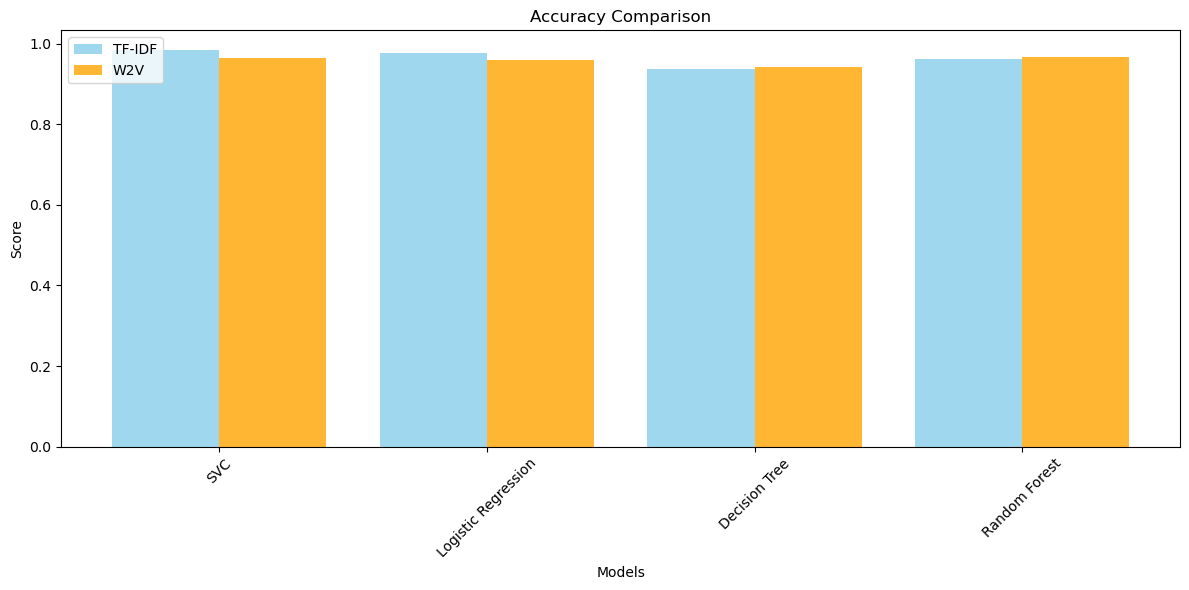

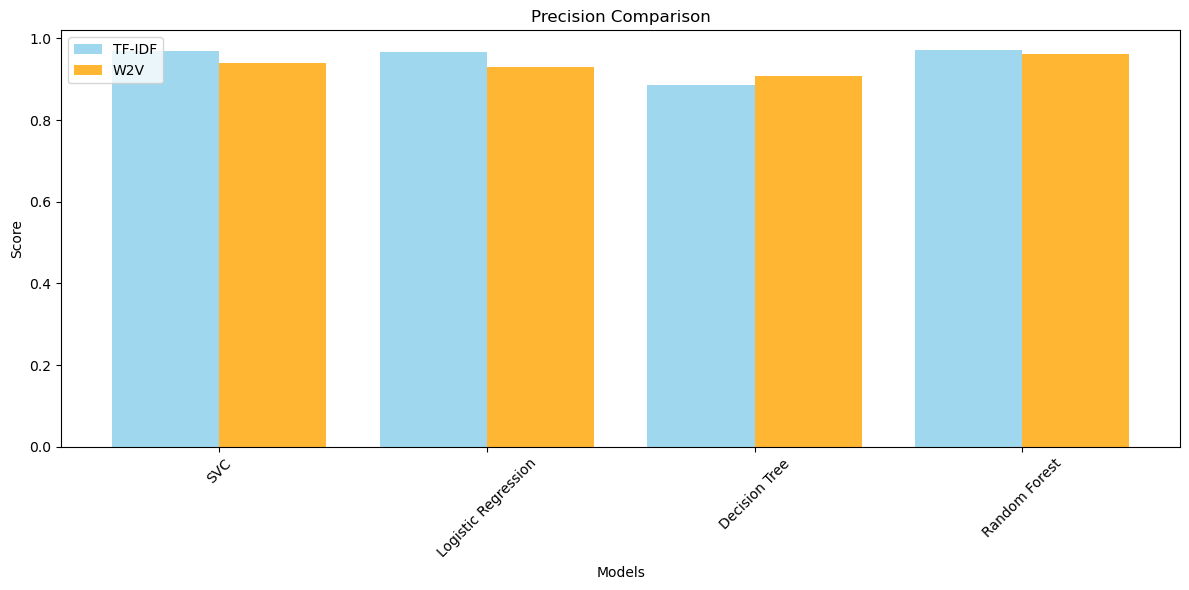

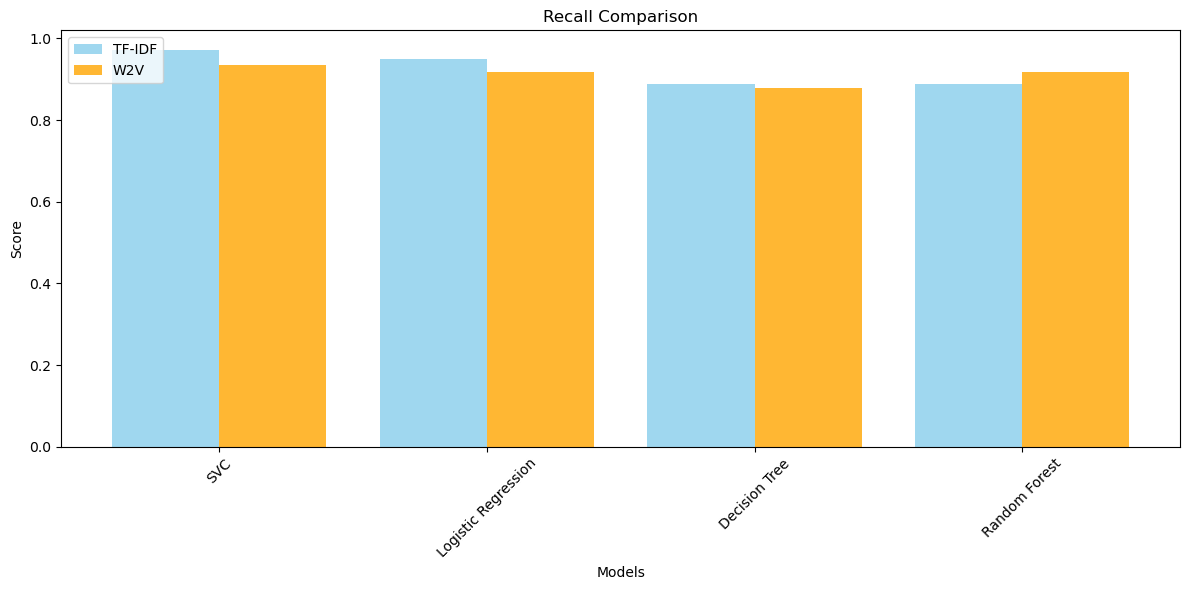

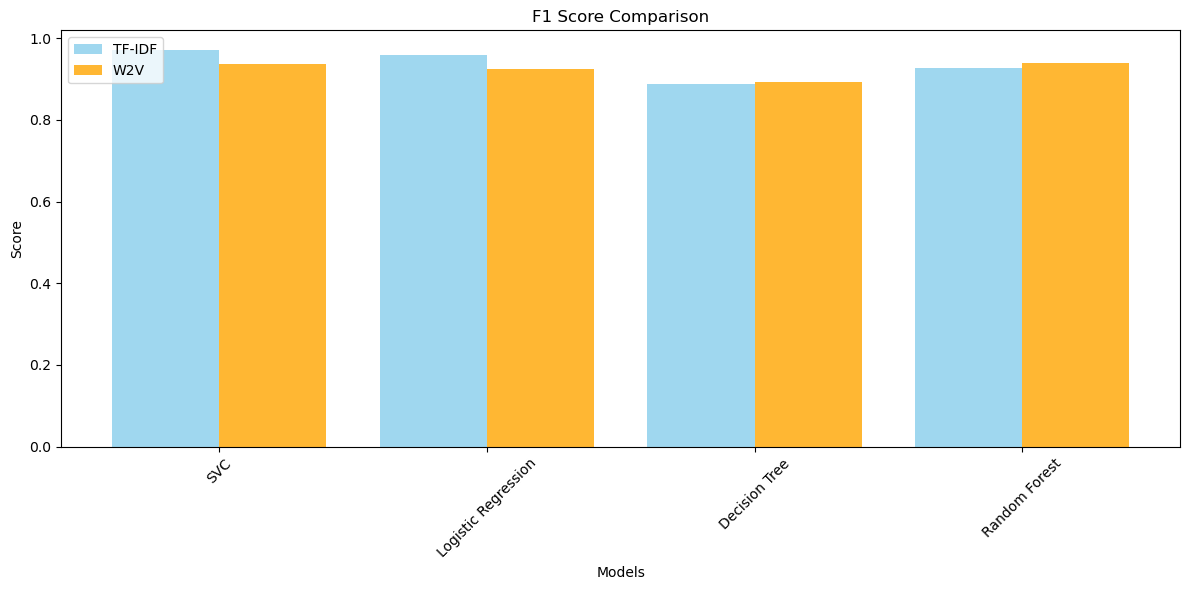

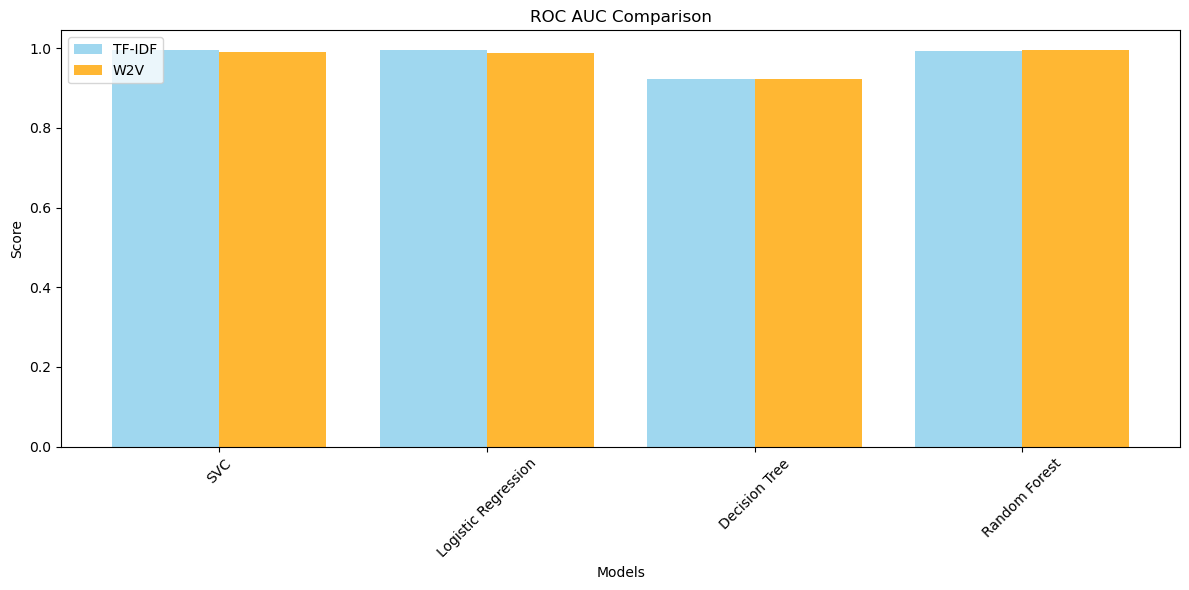

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Convertire il DataFrame in formato long per facilitare il plotting
results_long = results_df.melt(id_vars=["Metric"], var_name="Model", value_name="Score")

# Estrarre i modelli base
models = ["SVC", "Logistic Regression", "Decision Tree", "Random Forest"]

# Lunghezza dei modelli
num_models = len(models)

# Iterare su ogni metrica
metrics = results_df["Metric"]
for metric in metrics:
    # Filtrare i dati per la metrica corrente
    metric_data = results_long[results_long["Metric"] == metric]

    # Generare le posizioni per le barre
    x = np.arange(num_models)  # Posizioni base per i modelli
    bar_width = 0.4  # Larghezza delle barre

    # Separare i punteggi TF-IDF e W2V
    tfidf_scores = [metric_data[metric_data["Model"].str.contains(model) & metric_data["Model"].str.contains("TF-IDF")]["Score"].values[0] for model in models]
    w2v_scores = [metric_data[metric_data["Model"].str.contains(model) & metric_data["Model"].str.contains("W2V")]["Score"].values[0] for model in models]

    # Creare il grafico
    plt.figure(figsize=(12, 6))
    plt.bar(x, tfidf_scores, bar_width, label='TF-IDF', color='skyblue', alpha=0.8)
    plt.bar(x + bar_width, w2v_scores, bar_width, label='W2V', color='orange', alpha=0.8)

    # Personalizzare il grafico
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title(f"{metric} Comparison")
    plt.xticks(x + bar_width / 2, models, rotation=45)
    plt.legend(loc='upper left')
    plt.tight_layout()

    # Mostrare il grafico
    plt.show()


From the diagram we can see that the metrics are very similar, however slightly better those of the TF-IDF.

# **K-CROSS VALIDATION**

Although the `hold-out` approach provides a quick evaluation of the model, it is sensitive to how the data is split, potentially leading to unreliable results; therefore, I decided to use `k-fold cross-validation` for these reason:
- **Improved Reliability**: it reduces the impact of data variability by averaging performance across all folds.
- **Balanced Evaluation**: using `Stratified K-Fold`, I ensure each fold maintains the same proportion of spam and non-spam emails, preserving the class distribution.

By moving to k-fold cross-validation, I aim to gain a better estimate of the model's generalization performance, minimizing the risk of overfitting or underfitting due to a single train-test split. This process also helps to identify models that are consistently effective across different subsets of the data.  

In [55]:
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.pipeline import Pipeline
# StratifiedKFold initialisation (10 fold)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

X = email_text['transform_text']
Y = email_text['label']

For each model, the following steps were applied:

1. **Pipeline Creation**:
   - The pipeline included:
     - Text Vectorization: transforming email text into numerical features using `TfidfVectorizer`.
     - Model Training: training the specific machine learning algorithm (e.g., Random Forest, etc.).

2. **Cross-Validation**:
   - Used `Stratified K-Fold Cross-Validation` to evaluate model performance while preserving the class distribution in each fold.
   - Key metrics such as `accuracy`, `precision`, `recall`, and `f1-score` were computed for each fold.

3. **Performance Analysis**:
   - The metrics were averaged across all folds to provide a reliable estimate of each model's generalization performance.

This process ensured fair and reliable comparisons between models.


# **RANDOM-FOREST**

In [56]:
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorialisation of text data  
    ('model', RandomForestClassifier()) # Random Forest 
])

# Define metrics to be calculated during cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Use cross_validate to perform K-fold cross-validation with the pipeline
results_rf = cross_validate(
    pipeline_rf, 
    X,
    Y,
    cv=skf, 
    scoring=scoring, 
    return_train_score=False,      
    n_jobs=-1                      
)

cv_results_rf = pd.DataFrame(results_rf)

# Show results for each fold
print("Metrics Scores Across Folds:")
print(cv_results_rf[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']])

mean_results_rf = cv_results_rf[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']].mean()
print("Mean Metrics Across Folds:")
print(mean_results_rf)

Metrics Scores Across Folds:
   test_accuracy  test_precision  test_recall   test_f1
0       0.965438        0.979592     0.894410  0.935065
1       0.969470        0.990868     0.898551  0.942454
2       0.965438        0.977427     0.896480  0.935205
3       0.959101        0.963964     0.886128  0.923409
4       0.966590        0.984055     0.894410  0.937093
5       0.968318        0.984199     0.900826  0.940669
6       0.972350        0.978070     0.921488  0.948936
7       0.974078        0.978214     0.927686  0.952280
8       0.972350        0.982301     0.917355  0.948718
9       0.968894        0.973568     0.913223  0.942431
Mean Metrics Across Folds:
test_accuracy     0.968203
test_precision    0.979226
test_recall       0.905056
test_f1           0.940626
dtype: float64


# **DECISION-TREE**

In [57]:
pipeline_dt = Pipeline([
    ('tfidf', TfidfVectorizer()), # Vectorialisation of text data
    ('model', DecisionTreeClassifier())  # Decision Tree
])

# Define metrics to be calculated during cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Use cross_validate to perform K-fold cross-validation with the pipeline
results_dt = cross_validate(
    pipeline_dt, 
    X,
    Y,
    cv=skf, 
    scoring=scoring, 
    return_train_score=False,     # Not calculating metrics for the training set
    n_jobs=-1                      
)


cv_results_dt = pd.DataFrame(results_dt)

# Show results for each fold
print("Metrics Scores Across Folds:")
print(cv_results_dt[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']])

# Calculate and print averages of fold metrics
mean_results_dt = cv_results_dt[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']].mean()
print("Mean Metrics Across Folds:")
print(mean_results_dt)


Metrics Scores Across Folds:
   test_accuracy  test_precision  test_recall   test_f1
0       0.945276        0.894309     0.910973  0.902564
1       0.952765        0.923890     0.904762  0.914226
2       0.941820        0.888211     0.904762  0.896410
3       0.942972        0.891837     0.904762  0.898253
4       0.948157        0.906832     0.906832  0.906832
5       0.951613        0.906504     0.921488  0.913934
6       0.950461        0.902834     0.921488  0.912065
7       0.946429        0.888668     0.923554  0.905775
8       0.948157        0.895582     0.921488  0.908350
9       0.942972        0.893661     0.902893  0.898253
Mean Metrics Across Folds:
test_accuracy     0.947062
test_precision    0.899233
test_recall       0.912300
test_f1           0.905666
dtype: float64


# **LOGISTIC REGRESSION**

In [58]:
import joblib

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorialisation of text data
    ('model', LogisticRegression())  # Logistic Regression
])

# Define metrics to be calculated during cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Use cross_validate to perform K-fold cross-validation with the pipeline
results_lr = cross_validate(
    pipeline_lr, 
    X,
    Y,
    cv=skf, 
    scoring=scoring, 
    return_train_score=False, # Not calculating metrics for the training set
    return_estimator=True,
    n_jobs=-1                      
)

cv_results_lr = pd.DataFrame(results_lr)

# Show results for each fold
print("Metrics Scores Across Folds:")
print(cv_results_lr[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']])

# Calculate and print averages of fold metrics
mean_results_lr = cv_results_lr[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']].mean()
print("Mean Metrics Across Folds:")
print(mean_results_lr)


Metrics Scores Across Folds:
   test_accuracy  test_precision  test_recall   test_f1
0       0.976382        0.974249     0.939959  0.956797
1       0.983871        0.983015     0.958592  0.970650
2       0.979839        0.972574     0.954451  0.963427
3       0.975230        0.968085     0.942029  0.954879
4       0.977535        0.968354     0.950311  0.959248
5       0.979263        0.974576     0.950413  0.962343
6       0.978687        0.968553     0.954545  0.961498
7       0.983295        0.972973     0.966942  0.969948
8       0.982719        0.974895     0.962810  0.968815
9       0.980991        0.972746     0.958678  0.965661
Mean Metrics Across Folds:
test_accuracy     0.979781
test_precision    0.973002
test_recall       0.953873
test_f1           0.963327
dtype: float64


# **SVC**

In [59]:
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorialisation of text data
    ('model', SVC())  # SVC
])

# Define metrics to be calculated during cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Use cross_validate to perform K-fold cross-validation with the pipeline
results_svc = cross_validate(
    pipeline_svc, 
    X,
    Y,
    cv=skf, 
    scoring=scoring, 
    return_train_score=False,      # Not calculating metrics for the training set
    return_estimator=True,
    n_jobs=-1                     
)


cv_results_svc = pd.DataFrame(results_svc)

# Show results for each fold
print("Metrics Scores Across Folds:")
print(cv_results_svc[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']])

# Calculate and print averages of fold metrics
mean_results_svc = cv_results_svc[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']].mean()
print("Mean Metrics Across Folds:")
print(mean_results_svc)


Metrics Scores Across Folds:
   test_accuracy  test_precision  test_recall   test_f1
0       0.986751        0.981172     0.971014  0.976067
1       0.988479        0.979296     0.979296  0.979296
2       0.982719        0.968944     0.968944  0.968944
3       0.984447        0.975000     0.968944  0.971963
4       0.983295        0.970954     0.968944  0.969948
5       0.986751        0.985263     0.966942  0.976017
6       0.983295        0.969072     0.971074  0.970072
7       0.989631        0.981405     0.981405  0.981405
8       0.987327        0.979253     0.975207  0.977226
9       0.983871        0.971074     0.971074  0.971074
Mean Metrics Across Folds:
test_accuracy     0.985657
test_precision    0.976143
test_recall       0.972285
test_f1           0.974201
dtype: float64


In [76]:
import plotly.express as px
# Create a DataFrame that organises these averages
summary_dict = {
    'RandomForest': mean_results_rf,
    'LogisticRegression': mean_results_lr,
    'DecisionTree': mean_results_dt,
    'SVC': mean_results_svc,
}
    
summary_df = pd.DataFrame(summary_dict).T


summary_df.reset_index(inplace=True)
summary_df = summary_df.melt(id_vars=['index'], var_name='Metric', value_name='Score')


summary_df.rename(columns={'index': 'Model'}, inplace=True)


fig = px.bar(summary_df, 
             x="Model", 
             y="Score", 
             color="Metric", 
             barmode="group", 
             title="Model Performance Comparison", 
             labels={"Score": "Score", "Model": "Model", "Metric": "Metric"})


fig.show()

# Step 5: Validation

### Statistical Comparison of Models

To evaluate and compare the performance of the models, I performed the following steps:

1. **Selection of F1-Score as the Evaluation Metric**:
   - The F1-score was chosen as the primary evaluation metric because it provides a balanced measure that combines precision and recall. This metric is particularly suitable for spam detection tasks, where both false positives (ham emails misclassified as spam) and false negatives (spam emails misclassified as ham) can have significant implications.
   - By emphasizing the harmonic mean of precision and recall, the F1-score ensures that both types of errors are penalized equally, aligning well with the requirements of the problem domain.

2. **Wilcoxon Test:**:
   - To determine whether the observed differences in F1-scores across the models were statistically significant, I applied the Wilcoxon Test. This non-parametric test is used to compare two related samples, testing the null hypothesis that their population mean ranks are the same.
   - **Result Interpretation**:
     - A p-value less than 0.05 indicates significant differences, rejecting the null hypothesis.
     - A p-value greater than or equal to 0.05 suggests no significant differences.

3. **Visualization**:
   - A boxplot was generated to visualize the F1-score distribution across all cross-validation folds for each model, providing a clear picture of their performance variability.

4. **Error Rate Calculation:**:
   - For each model, the Error Rate was calculated as **1−F1-score**. This reflects how well each model performs, with a lower error rate indicating better performance.

In [71]:
from itertools import combinations
from scipy.stats import wilcoxon
import pandas as pd

# Dati F1-score per ogni modello
f1_scores = {
    'RandomForest': cv_results_rf['test_f1'],
    'LogisticRegression': cv_results_lr['test_f1'],
    'DecisionTree': cv_results_dt['test_f1'],
    'SVC': cv_results_svc['test_f1'],
}

# Genera tutte le combinazioni di coppie di modelli
model_pairs = list(combinations(f1_scores.keys(), 2))

# Contenitore per i risultati
wilcoxon_results = []

# Applica il Wilcoxon test a ciascuna combinazione
for model1, model2 in model_pairs:
    stat, p = wilcoxon(f1_scores[model1], f1_scores[model2])
    wilcoxon_results.append({
        'Model 1': model1,
        'Model 2': model2,
        'Statistic': stat,
        'p-value': p,
        'Significant': p < 0.05
    })

# Converti i risultati in un DataFrame
wilcoxon_df = pd.DataFrame(wilcoxon_results)

# Mostra i risultati
print(wilcoxon_df)


              Model 1             Model 2  Statistic   p-value  Significant
0        RandomForest  LogisticRegression        0.0  0.001953         True
1        RandomForest        DecisionTree        0.0  0.001953         True
2        RandomForest                 SVC        0.0  0.001953         True
3  LogisticRegression        DecisionTree        0.0  0.001953         True
4  LogisticRegression                 SVC        0.0  0.001953         True
5        DecisionTree                 SVC        0.0  0.001953         True


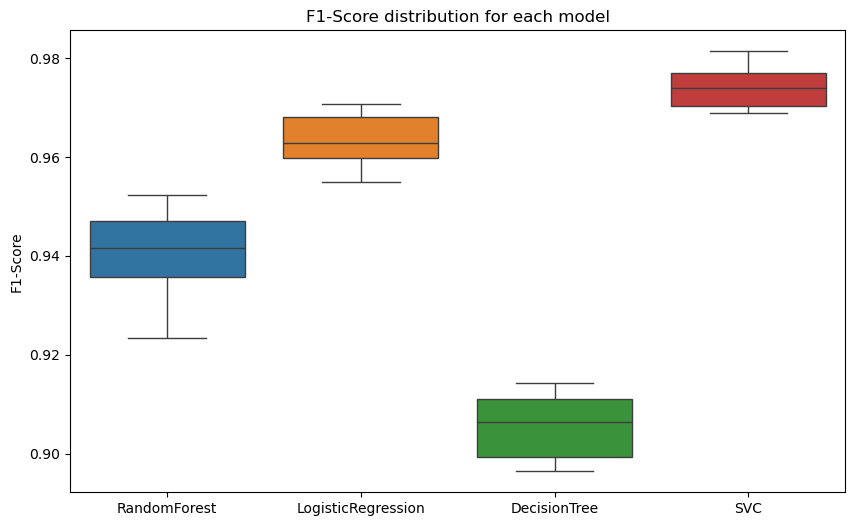

In [77]:
import scikit_posthocs as sp

# Boxplot to display F1-Score distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=f1_scores)
plt.title("F1-Score distribution for each model")
plt.ylabel("F1-Score")
plt.show()


In [75]:
error_rate_rf = round(1 - mean_results_rf['test_f1'], 3)
error_rate_lr = round(1 - mean_results_lr['test_f1'], 3)
error_rate_dt = round(1 - mean_results_dt['test_f1'], 3)
error_rate_svc = round(1 - mean_results_svc['test_f1'], 3)

# Display the error rates for all models
print("Random Forest - Error Rate:", error_rate_rf)
print("Logistic Regression - Error Rate:", error_rate_lr)
print("Decision Tree - Error Rate:", error_rate_dt)
print("SVC - Error Rate:", error_rate_svc)


Random Forest - Error Rate: 0.059
Logistic Regression - Error Rate: 0.037
Decision Tree - Error Rate: 0.094
SVC - Error Rate: 0.026


# Step 6: Reporting

## 1. References
The references I consulted have been a valuable guide throughout this research. They provided essential insights into the models and techniques used, allowing me to understand the underlying methodologies in depth. Furthermore, they served as a benchmark for comparing my results with those reported in the literature, helping me assess whether my findings were consistent with or deviated from existing studies. 

1. *Classification of Phishing Email Using Word Embedding and Machine Learning Techniques* - https://www.researchgate.net/publication/360456225_Classification_of_Phishing_Email_Using_Word_Embedding_and_Machine_Learning_Techniques
2. *Spam Email Detection Using Deep Learning Techniques* - https://www.sciencedirect.com/science/article/pii/S1877050921007493
3. *Comparative Analysis of Machine Learning Algorithms for Email Phishing Detection Using TF-IDF, Word2Vec, and BERT* https://www.sciencedirect.com/org/science/article/pii/S1546221824008117
4. *Comparative Analysis of Machine Learning and Deep Learning for Email Spam Detection* - https://www.techrxiv.org/users/802623/articles/1187484-comparative-analysis-of-machine-learning-and-deep-learning-for-email-spam-detection  

Although some of the references focus on phishing email detection, their methodologies and findings provide significant insights into spam email detection due to shared characteristics in text processing, feature extraction, and classification.


## 2. Proposal for Improvements and New Goals

### Possible Improvements

1. **Hybrid Feature Representation**: Combine Word2Vec and TF-IDF to leverage semantic richness and frequency-based insights.

2. **Hyperparameter Tuning**: Optimize hyperparameters for Random Forest and XGBoost to improve classification performance.

3. **Data Augmentation**: Enhance the dataset with additional spam and ham emails to improve training.

### New Goals and Future Directions

1. **Incorporating Deep Learning Models**: Investigate transformer-based models like BERT for email spam detection, as proposed in Reference 3.

2. **Handling Imbalanced Data**: Implement advanced techniques like SMOTE for better handling of class imbalances.


# Real Time Classifier

In [65]:
import joblib
joblib.dump(results_svc['estimator'][0], 'spam_detection_model.joblib')

['spam_detection_model.joblib']